In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


import sys
sys.path.append('../../..')
from batchflow.opensets import Imagenette160
from batchflow import Pipeline, B, V, C, W

from batchflow.models.torch import ResNet34, ResBlock, SelfAttention
from batchflow.models.torch.layers import ConvBlock

from batchflow.models.metrics import ClassificationMetrics
from batchflow.research import Research, Option, Results, KV, RP, REU, RI
from batchflow.utils import plot_results_by_config, show_research, print_results

In [2]:
# Global constants
NUM_ITERS = 50000                               # number of iterations to train each model for
N_REPS = 5                                      # number of times to repeat each model train
RESEARCH_NAME = 'research'                      # name of Research object
DEVICES = [3, 4, 5, 6, 7]                       # devices to use
WORKERS = len(DEVICES)                          # number of simultaneously trained models
TEST_FREQUENCY = 150

dataset = Imagenette160()                       # dataset to train models on

In [3]:
domain = (Option('se', [True, True, False]) @ Option('ratio', [4, 16, None]))

In [4]:
config = {
    'inputs/images/shape': (3, 160, 160),
    'initial_block/inputs': 'images',
    'inputs/labels/classes': 10,
    'body/encoder/blocks/se': C('se'),
    'body/encoder/blocks/ratio': C('ratio'),
    'head/layout': 'Vf',
    'head/units': 10,
    "decay": dict(name='exp', gamma=0.15),
    "n_iters": 10000,
    'device': C('device'),
}

In [5]:
train_root = (dataset.train.p      
                  .crop(shape=(160, 160), origin='center')
                  .to_array(channels='first', dtype=np.float32)
                  .multiply(multiplier=1/255)
                  .run_later(64, n_epochs=None, drop_last=True,
                             shuffle=True, prefetch=5)
                   )

train_pipeline = (Pipeline()
                  .init_variable('loss')
                  .init_model('dynamic', ResNet34, 'my_model', config=config) 
                  .train_model('my_model', B('images'), B('labels'), 
                               fetches='loss', save_to=V('loss'))
                 )

In [6]:
def acc(iteration, import_from):
    pipeline = (dataset.test.p
                 .import_model('my_model', import_from)
                 .init_variable('true', [])
                 .update(V('true', mode='a'), B.labels) 
                 .init_variable('predictions', [])
                 .crop(shape=(160, 160), origin='center')
                 .to_array(channels='first', dtype=np.float32)
                 .multiply(multiplier=1/255)
                 .predict_model('my_model', B('images'), fetches='predictions',
                                save_to=V('predictions', mode='a'))
                 )
    pipeline.run(128, n_epochs=1, drop_last=False, shuffle=True)
    pred = np.concatenate(pipeline.v('predictions'))
    true = np.concatenate(pipeline.v('true'))
    accuracy = ClassificationMetrics(true, pred, fmt='logits',
                                     num_classes=10, axis=1).accuracy()
    return accuracy

In [7]:
research = (Research()
            .init_domain(domain, n_reps=N_REPS)
            .add_pipeline(root=train_root, branch=train_pipeline, variables='loss',
                          name='train_ppl', logging=True)
            .add_callable(acc, returns='acc_vall', name='acc_fn', execute=TEST_FREQUENCY,
                          iteration=RI(), import_from=RP('train_ppl')))

In [8]:
!rm -rf research
research.run(NUM_ITERS, name=RESEARCH_NAME,
             devices=DEVICES, workers=WORKERS,
             bar=True)

Research research is starting...


Domain updated: 0: 100%|██████████| 750000/750000.0 [20:01:01<00:00, 10.41it/s]  


In [9]:
%%time
results = Results(path=RESEARCH_NAME, concat_config=True)

CPU times: user 32min 58s, sys: 24 ms, total: 32min 58s
Wall time: 32min 58s


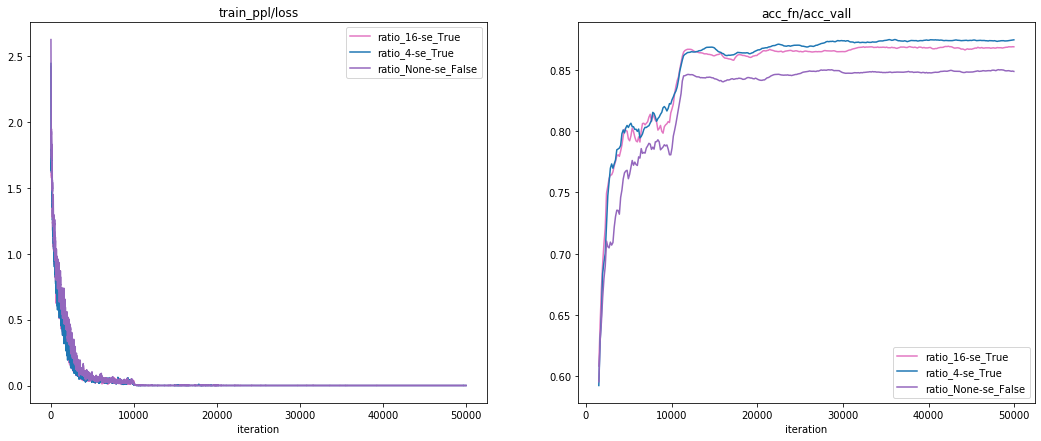

In [10]:
show_research(results.df, layout=['train_ppl/loss', 'acc_fn/acc_vall'], average_repetitions=True, 
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=False, rolling_window=10)

In [11]:
print_results(results.df, 'acc_fn/acc_vall', False, ascending=True, n_last=100)

,acc_fn_0,acc_fn_4,acc_fn_2,acc_fn_1,acc_fn_3,acc_fn_mean,acc_fn_std
ratio_16-se_True,0.878850,0.870637,0.866530,0.860370,0.866530,0.868583,0.006091
ratio_4-se_True,0.872690,0.882957,0.878850,0.866530,0.878850,0.875975,0.005749
ratio_None-se_False,0.856263,0.848049,0.835729,0.848049,0.854209,0.848460,0.007160
